# Results of Edge Detection Benchmark and Speedup

By: Ricardo Pina

# Trouble Shooting

when initially trying to run the prgram per the instructions:
```
make clean
make
make test
```
I received a
`/opt/software/binutils/2.28-GCCcore-6.4.0/bin/ld: cannot find -lpng16` 
as the modules were not loaded in, I was not aware of this being a module however, so I investigated by looking at the makefile.

I noticed that the makefile had two lines where there was lpng16 and png16, I thought this might have been the issue so I trouble-shooted a little bit here by spelling them the same, I still don't understand why one has the -l flag and is apelled lpng16 and the other is not but never the less this was not the issue, I realized that these were modules so I investigated the web briefly before using spider.

`module spider png` yielded the png module libpng, but I was not sure this is what I needed I used spider again `module spider libpng/1.6.37` to investigate further and spider indicated to me that in order to use this module I would have to load one of the GCCcore module. I loaded `module load GCCcore/9.3.0` and then proceeded to load `module load libpng/1.6.37`. make and make test finally worked and I was able to see that the boximage was succesfully edge detected.


## Serial Experiment

I compiled the serial code on the HPCC with dev-amd20 using the following commands:

make clean\

module load GCCcore/9.3.0\
module load libpng/1.6.37

make test\
make earth\
make sparty\
make stadium

bash serial.sh

I used the basic `salloc -N 1 --ntasks-per-node 1 --mem 1gb --time 00:10:00` command to keep the serial results consistent, I did this to help establish a control and it makes it easier to identify the Job requests/environment variables, using the `env | grep SLURM` command.

## Updated 3/1

I wrote the sbatch file `serial_all.sb` this sbatch removes all old average times calculated from the subdirectory serial_time and the edge detected images from the subdirectory images, the command sends a single core Job for all images with ten compilations done to calculate an average time. The sbatch is equivalent to the salloc command as far as I am aware, it just keeps things reproducable.

I used 1 node, set the memory really high, and set 1 cpu per task, this is a serial task so this is redundant but again it keeps the program to act as a control and ensures some form of reproducability. I used the same for the optimization in the next section to easily compare speedups with the single variable analysis of the only using an optimization flag.

Iniitialization commands below:
```
#!/bin/bash --login
#SBATCH --nodes=1
#SBATCH --mem-per-cpu=10000
#SBATCH --cpus-per-task=1
#SBATCH --time=00:10:00

module load GCCcore/9.3.0
module load libpng/1.6.37

make clean
make

mkdir -p serial_time
```


10 runs for all, txt files with data in serial_time:\
earth.png:  8.0826 seconds \
sparty.png: .2515 seconds \
MSUStadium.png: .316 seconds

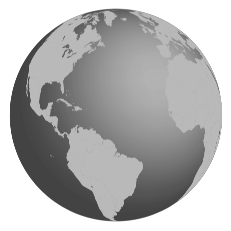

In [110]:
%matplotlib inline
import matplotlib.pylab as plt
import imageio

filename = './serial/images/earth.png'

im = imageio.imread(filename)
    
#Show the image
plt.imshow(im, cmap='gray');
plt.axis('off');

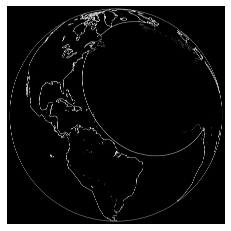

In [111]:
filename = './serial/images/earth_s.png'

im = imageio.imread(filename)
    
#Show the image
plt.imshow(im, cmap='gray');
plt.axis('off');

In [112]:
txt_file = './serial/serial_time/time_earth'
time_earth = open(r'C:\\Users\pinar\Downloads\Jupyter\edge_detection\serial\serial_time\time_earth.txt', 'r')

print(time_earth.read())

print(
"""
Here we can see the data for earth.png, 
we can do this for all png files but earth 
is the most interesting because it is the most 
computationally expensive and as such the improvements
in optimization are felt to a greater degree by human observers.

"""
)

        
    
time_earth.close




real	0m8.695s
user	0m8.506s
sys	0m0.107s

real	0m8.590s
user	0m8.471s
sys	0m0.103s

real	0m8.678s
user	0m8.544s
sys	0m0.091s

real	0m8.701s
user	0m8.571s
sys	0m0.105s

real	0m8.688s
user	0m8.581s
sys	0m0.092s

real	0m8.668s
user	0m8.560s
sys	0m0.094s

real	0m8.646s
user	0m8.535s
sys	0m0.097s

real	0m8.638s
user	0m8.528s
sys	0m0.095s

real	0m8.617s
user	0m8.502s
sys	0m0.093s

real	0m8.723s
user	0m8.614s
sys	0m0.092s

The average time after 10 runs is 8.6644


Here we can see the data for earth.png, 
we can do this for all png files but earth 
is the most interesting because it is the most 
computationally expensive and as such the improvements
in optimization are felt to a greater degree by human observers.




<function TextIOWrapper.close()>

In [113]:
def times_extract(times):
    time_list = []
    while(True):
        line = times.readline()
        if not line:
            break
        if 'real' in line:
            time_list.append(float(line.strip()[7:12]))
    times.close
    return time_list

The distribution of our serial run times, we will do this for all earth_pngs and compare them accordingle by the end of the Report

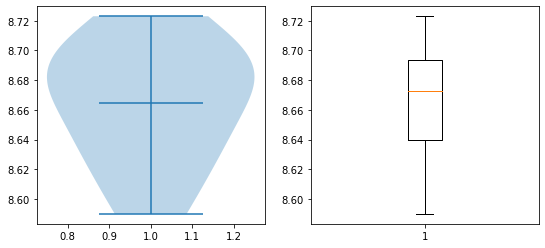

In [114]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

earth_t = times_extract(open(r'C:\\Users\pinar\Downloads\Jupyter\edge_detection\serial\serial_time\time_earth.txt', 'r')
)

msustadium_t = times_extract(open(r'C:\\Users\pinar\Downloads\Jupyter\edge_detection\serial\serial_time\time_msustadium.txt', 'r')
)
sparty_t = times_extract(open(r'C:\\Users\pinar\Downloads\Jupyter\edge_detection\serial\serial_time\time_sparty.txt', 'r')
)

# plot violin plot
axs[0].violinplot(earth_t,
                  showmeans=True,
                  showmedians=False)

# plot box plot
axs[1].boxplot(earth_t)

plt.show()

## Code Optimization

###Describe changes you made to the code to try and make it go faster### 

* changed the flags on the GCC compiler optimization options in the makefile. Following lines changed:

```
main_process.o: main_process.c
    gcc -O3 -std=c99 -c main_process.c 

png_util.o: png_util.c
    gcc -O3 -std=c99 -l lpng16 -c png_util.c

process: main_process.o png_util.o
    gcc -O3 -std=c99 -o process -lm -l png16 main_process.o png_util.o
```

This lowered the average time by a substantial amount from 8.0826 seconds on the earth png to 2.397 seconds. This is about 3.3 times faster, the increases to the other pngs are from 
.25 to .106 and .316 to .1366.

* Changed the salloc options of \
`salloc -N 1 --ntasks-per-node 1 --mem 1gb --time 00:10:00` to \
`salloc -N 1 --ntasks-per-node 10 --mem 10gb --time 00:10:00`

This also lowered the average time by a few milliseconds
The new times achieved were:
2.3791
.096
.1355

## Updated 3/1

I used the same sbatch file `serial_all.sb` just renamed `optimized_all.sb` This is still serial so any modification to the sbatch environment variables are a little unnecessary, also this allows the univariate comparison of the serial and optimized to be more impactful based on the inclusion of the flag alone -O3.

Iniitialization commands below:
```
#!/bin/bash --login
#SBATCH --nodes=1
#SBATCH --mem-per-cpu=10000
#SBATCH --cpus-per-task=1
#SBATCH --time=00:10:00

module load GCCcore/9.3.0
module load libpng/1.6.37

make clean
make

mkdir -p serial_time
```


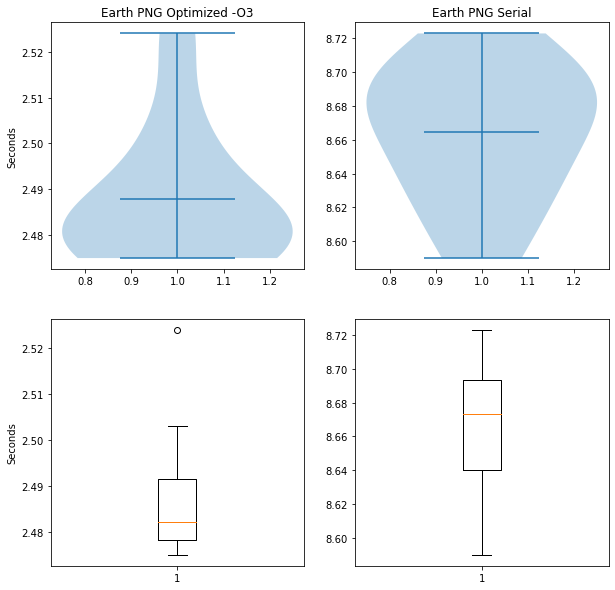

In [131]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

earth_t_opt = times_extract(open(r'C:\\Users\pinar\Downloads\Jupyter\edge_detection\optimized\optimized_times\time_earth.txt', 'r')
)
msustadium_t_opt = times_extract(open(r'C:\\Users\pinar\Downloads\Jupyter\edge_detection\optimized\optimized_times\time_msustadium.txt', 'r')
)
sparty_t_opt = times_extract(open(r'C:\\Users\pinar\Downloads\Jupyter\edge_detection\optimized\optimized_times\time_sparty.txt', 'r')
)

# plot violin plot
axs[0][0].violinplot(earth_t_opt,
                  showmeans=True,
                  showmedians=False)
axs[0][0].set_title('Earth PNG Optimized -O3')
axs[0][0].set_ylabel('Seconds')

axs[0][1].violinplot(earth_t,
                  showmeans=True,
                  showmedians=False)
axs[0][1].set_title('Earth PNG Serial')

# plot box plot
axs[1][0].boxplot(earth_t_opt)
axs[1][1].boxplot(earth_t)
axs[1][0].set_ylabel('Seconds')

plt.show()

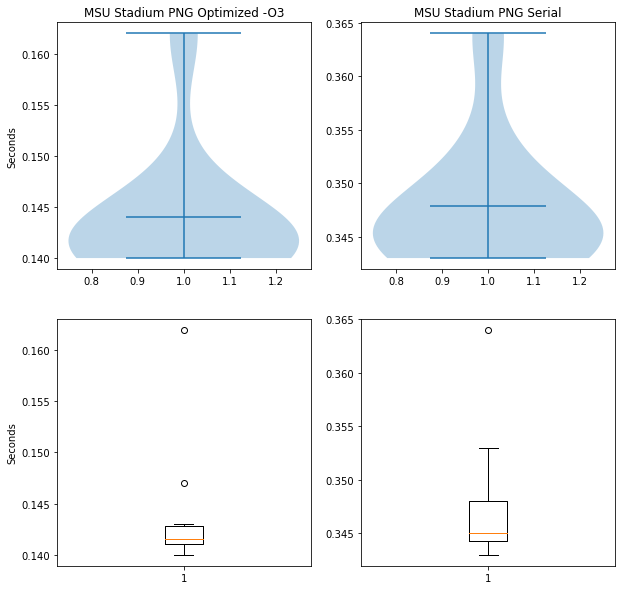

In [130]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# plot violin plot
axs[0][0].violinplot(msustadium_t_opt,
                  showmeans=True,
                  showmedians=False)
axs[0][0].set_title('MSU Stadium PNG Optimized -O3')
axs[0][0].set_ylabel('Seconds')

axs[0][1].violinplot(msustadium_t,
                  showmeans=True,
                  showmedians=False)
axs[0][1].set_title('MSU Stadium PNG Serial')

# plot box plot
axs[1][0].boxplot(msustadium_t_opt)
axs[1][1].boxplot(msustadium_t)
axs[1][0].set_ylabel('Seconds')

plt.show()

## OpenMP Speedup Updated 3/1

I had real issues with collapsing and parallelization, this was because I was confusing nodes and cores, once I made this realization I was able to hone in on the parts of the most computationally expensive loops.

I was still getting weird errors however, it  wasn't until I redownloaded the main program that I got anything working. I discovered the collapse and found where I could easily apply it, which was in various places in the program with two nested for loops however I knew these were not computationally expensive, but it was nice being able to code for them and test things out.
```
//#pragma omp parallel for schedule(static) collapse(2)
	for(int i=0;i<3;i++) 
		for(int j=0;j<3;j++)
			yfilter[j][i] = xfilter[i][j];
```

The computationally expensive loops are clearly where the gradient filter is applied and the average filter.
when img_size increases times increase exponentially.

When the first collapse on the first computationally expensive loop was applied times dropped to 2 seconds, after this applying the next one droopped times to one second for the earth.PNG.
I wanted to apply collapse on the outside of these loops and more intricate parallizations on other parts, this just was not coming together and I figured the improvements were good enough.



Iniitialization commands below:
```
#!/bin/bash --login
#SBATCH --nodes=1
#SBATCH --cpus-per-task=100
#SBATCH --time=00:10:00

module load GCCcore/9.3.0
module load libpng/1.6.37

make clean
make

mkdir -p omp_times
```

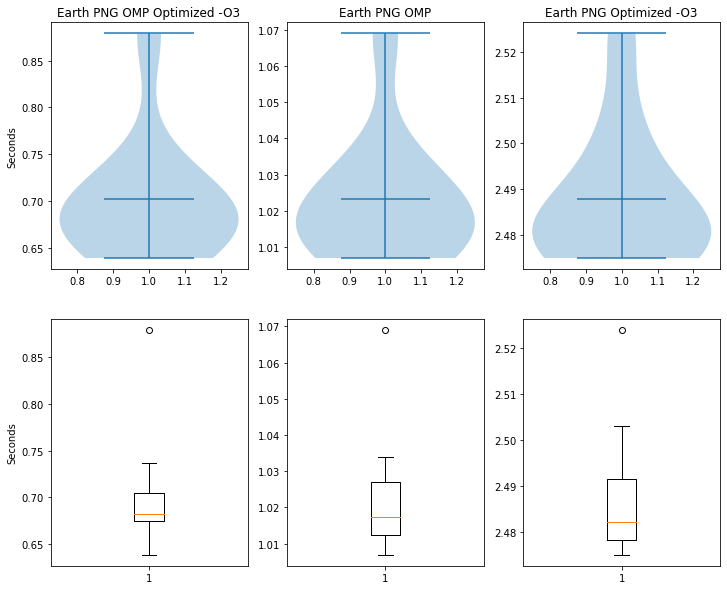

In [133]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))

earth_t_opt_omp = times_extract(open(r'C:\\Users\pinar\Downloads\Jupyter\edge_detection\omp_optimized\omp_times\time_earth.txt', 'r')
)
msustadium_t_opt_omp = times_extract(open(r'C:\\Users\pinar\Downloads\Jupyter\edge_detection\omp_optimized\omp_times\time_msustadium.txt', 'r')
)
sparty_t_opt_omp = times_extract(open(r'C:\\Users\pinar\Downloads\Jupyter\edge_detection\omp_optimized\omp_times\time_sparty.txt', 'r')
)

earth_t_omp = times_extract(open(r'C:\\Users\pinar\Downloads\Jupyter\edge_detection\omp\omp_times\time_earth.txt', 'r')
)
msustadium_t_omp = times_extract(open(r'C:\\Users\pinar\Downloads\Jupyter\edge_detection\omp\omp_times\time_msustadium.txt', 'r')
)
sparty_t_omp = times_extract(open(r'C:\\Users\pinar\Downloads\Jupyter\edge_detection\omp\omp_times\time_sparty.txt', 'r')
)

# plot violin plot
axs[0][0].violinplot(earth_t_opt_omp,
                  showmeans=True,
                  showmedians=False)
axs[0][0].set_title('Earth PNG OMP Optimized -O3')
axs[0][0].set_ylabel('Seconds')

axs[0][1].violinplot(earth_t_omp,
                  showmeans=True,
                  showmedians=False)
axs[0][1].set_title('Earth PNG OMP')

axs[0][2].violinplot(earth_t_opt,
                  showmeans=True,
                  showmedians=False)
axs[0][2].set_title('Earth PNG Optimized -O3')

# plot box plot
axs[1][0].boxplot(earth_t_opt_omp)
axs[1][1].boxplot(earth_t_omp)
axs[1][2].boxplot(earth_t_opt)
axs[1][0].set_ylabel('Seconds')

plt.show()

## Concluding Discussion

I find the shape of the optimizations very interesting, they are for the most part very concentrated at the bottom end, however they tend to have at least 1 or 2 relatively large outliers, for a larger data set it would be interesting to see so many outliers, since they seem to be around 10-20% of the data set.

Also while we are analyzing time and execution speed, I would have thought it very interesting to see if their was anything funky going on with the images due to -O3 flags and parallization, I get the feeling that parallelization may lead to small mistakes and that the output of an image may result in incorrect math being computed and the image being distorted I am curious if this occurs and how often on larger scales.

On SLURM:
I don't think their is a difference between cores and threads, when trying to specify more than 1 thread work at a time while initializing cores I got errors.

I was testing somethings and I purposefully left out `#SBATCH` instrucions out of my sbatch scripts in order to see what was doing what, however I got these weird 'core' files, and you can see them on my GitLab, I have no idea what they are.

I really want to be better versed with OMP parallel I felt like their were locations were I could have added one more line of #pragma commands. Specifically inside the nested quadra for loops

When running Bash commands I realized that loading the modules did not do anything for setting my environment variables, perhaps we covered this in class but I could not figure out how to look at the environment variables in a meaningful way, for both slurm and the regular environment.



----